# Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [19]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import cv2
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from datetime import datetime
import utils
import model

from keras.preprocessing.image import ImageDataGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Set some parameters
_imgWidth = 256
_imgHeight = 256
_imgChannels = 3
_trainPath = './stage1_train_fixed/'
_valPath = './extra_data/'
_testPath = './stage2_test_final/'

# Root directory of the project
_rootDir = os.getcwd()

# Directory to save logs and trained model
_modelDir = os.path.join(_rootDir, "logs")

# Get the data

Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!


In [3]:
train_ids, X_train, Y_train = utils.load_dataset(_trainPath, _imgWidth, _imgHeight, _imgChannels, testData = False)

Getting and resizing images ... 


  0%|          | 0/665 [00:00<?, ?it/s]/tmp/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
 73%|███████▎  | 483/665 [02:37<00:59,  3.07it/s]

.ipynb_checkpoints


100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

Done!


In [4]:
val_ids, X_val, Y_val = utils.load_dataset(_valPath, _imgWidth, _imgHeight, _imgChannels, testData = False)

Getting and resizing images ... 


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 30/30 [05:21<00:00, 10.71s/it]

no failed ids
Done!


In [5]:
test_ids, X_test, sizes_test = utils.load_dataset(_testPath, _imgWidth, _imgHeight, _imgChannels, testData = True)

Getting and resizing images ... 


  0%|          | 0/3021 [00:00<?, ?it/s]/tmp/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
 16%|█▌        | 487/3021 [00:14<01:13, 34.65it/s]

646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0


 41%|████      | 1237/3021 [00:35<00:51, 34.87it/s]

__pycache__


 69%|██████▉   | 2086/3021 [00:59<00:26, 34.79it/s]

.ipynb_checkpoints


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

Done!



Let's see if things look all right by drawing some random images and their associated masks.


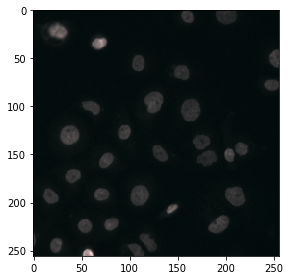

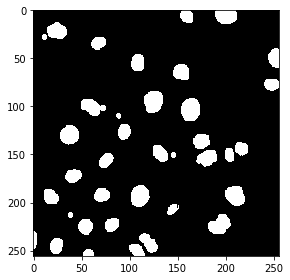

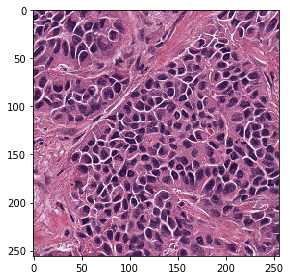

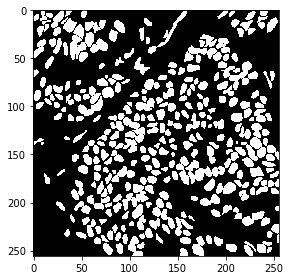

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()


# Check if validation data looks all right
ix = random.randint(0, len(val_ids))
imshow(X_val[ix])
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [75]:
u_net = model.build_model(_imgWidth, _imgWidth, _imgChannels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 8)  224         lambda_3[0][0]                   
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 8)  584         conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [76]:
#model.fit_model(u_net, _modelDir, X_train, Y_train)
#model.fit_model_generator(u_net, _modelDir, _rootDir, X_train, Y_train, X_val, Y_val)
#"""
seed = 42
batchSize = 4
    
trainDataGenArgs = dict(horizontal_flip=True,
                     featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)

trainImageDatagen = ImageDataGenerator(**trainDataGenArgs)
trainMaskDatagen = ImageDataGenerator(**trainDataGenArgs)
trainImageDatagen.fit(X_train, seed = seed)
trainMaskDatagen.fit(Y_train, seed = seed)
trainImageGenerator = trainImageDatagen.flow(X_train, batch_size=batchSize, shuffle=True, seed=seed, save_to_dir=None)
trainMaskGenerator = trainMaskDatagen.flow(Y_train, batch_size=batchSize, shuffle=True, seed=seed, save_to_dir=None)
#combine generators into one which yields image and masks
trainGenerator = zip(trainImageGenerator, trainMaskGenerator)
    
#"""

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


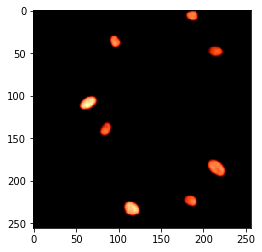

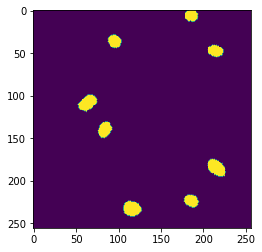

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


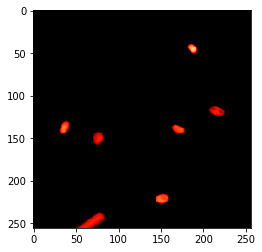

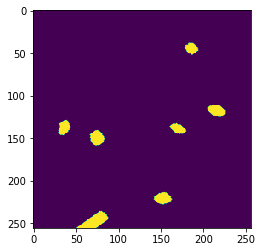

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


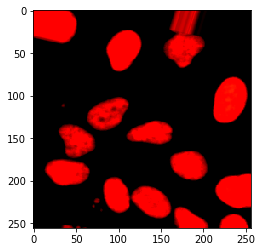

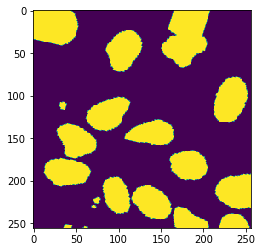

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


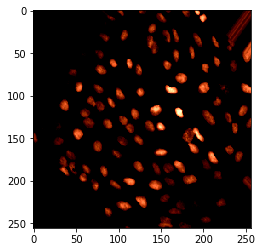

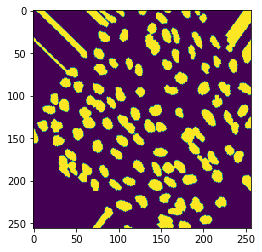

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


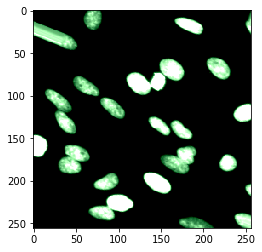

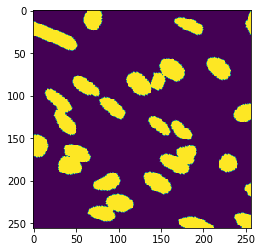

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


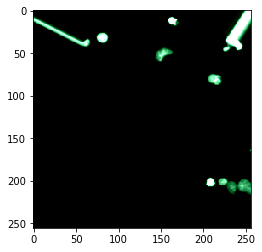

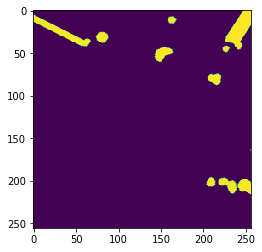

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


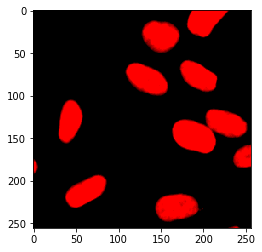

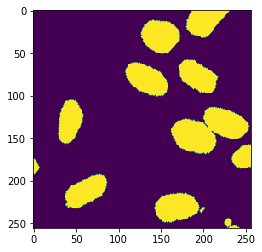

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


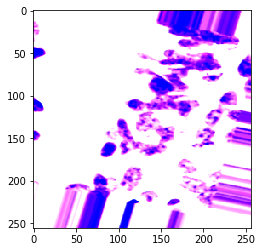

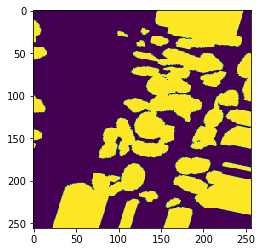

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


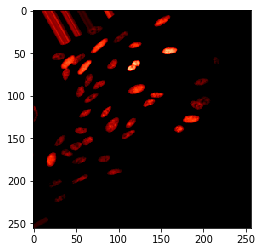

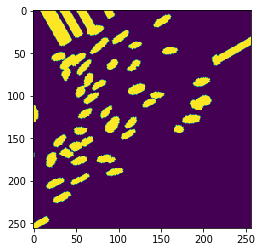

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


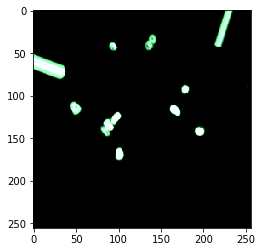

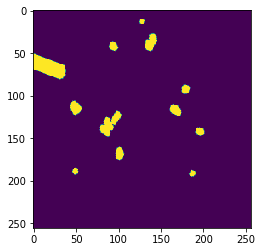

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


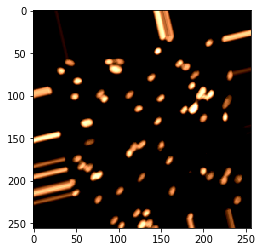

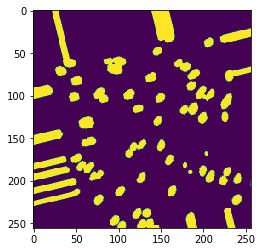

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


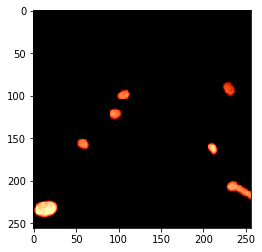

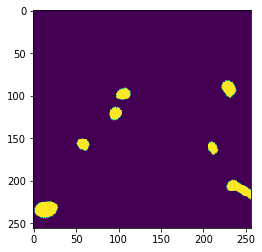

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


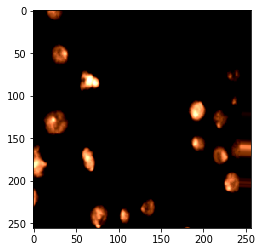

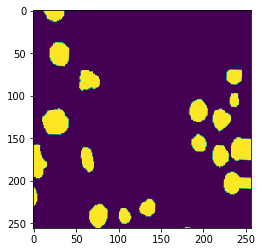

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


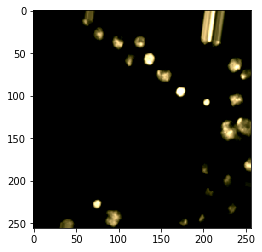

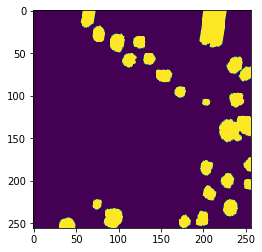

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


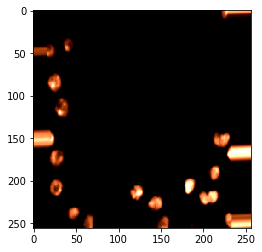

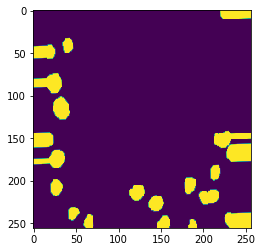

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


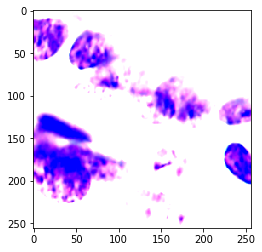

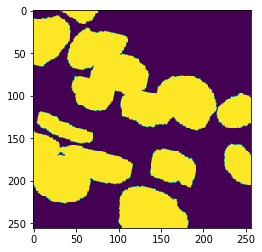

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


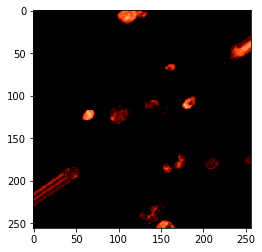

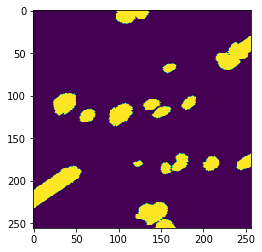

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


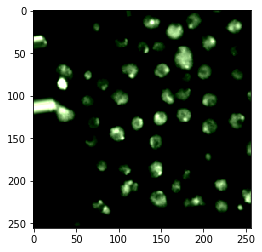

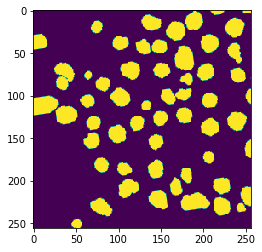

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


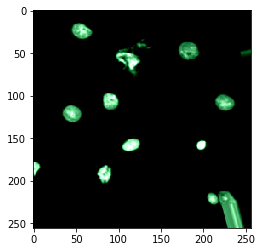

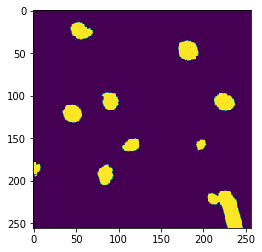

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


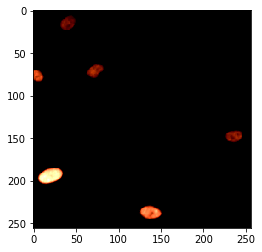

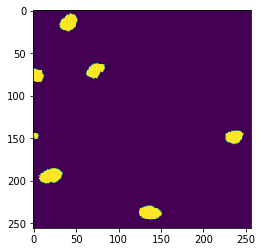

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


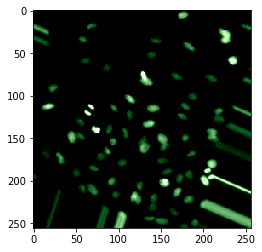

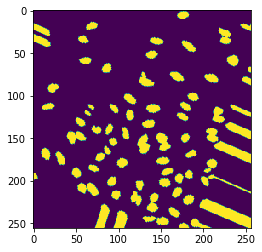

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


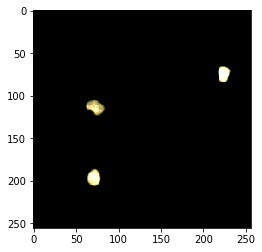

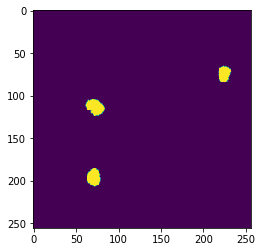

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


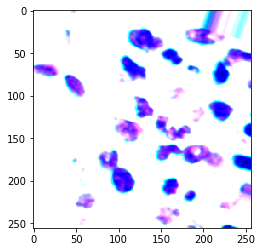

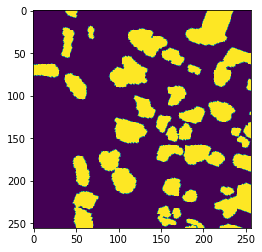

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


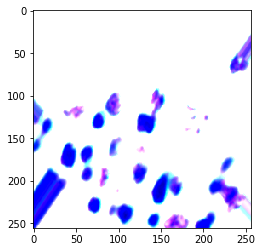

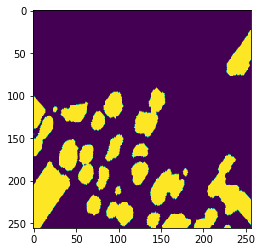

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


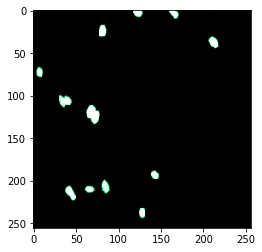

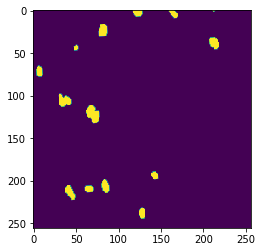

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


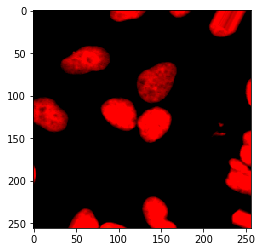

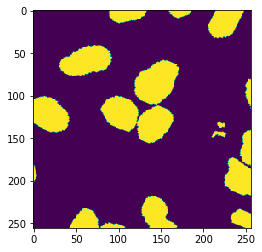

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


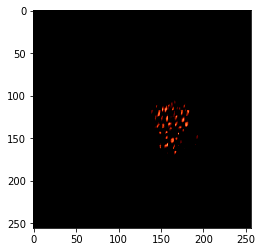

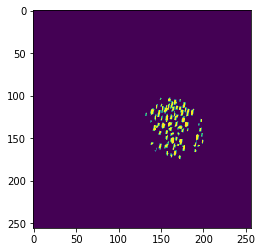

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


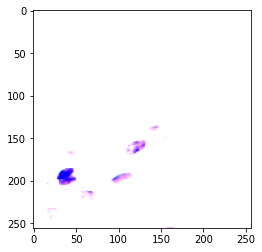

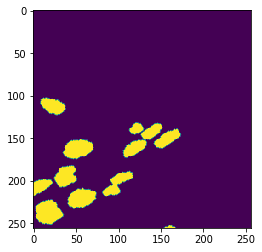

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


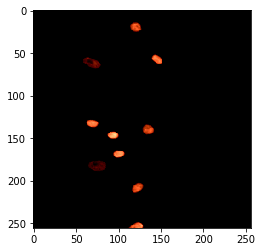

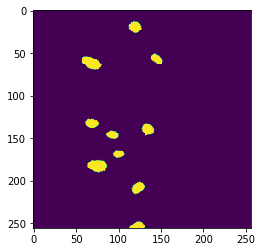

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


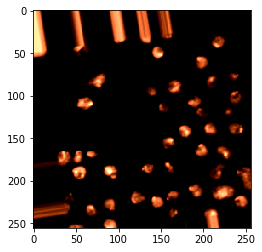

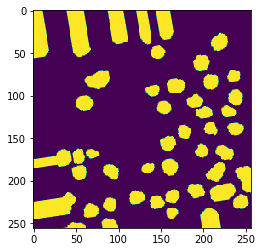

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


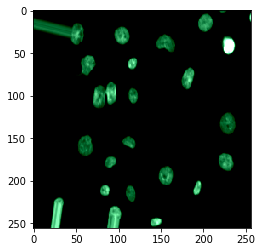

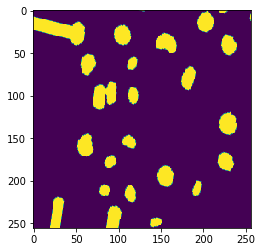

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


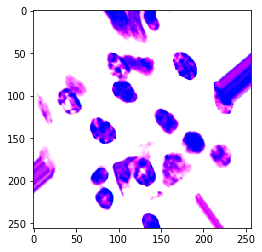

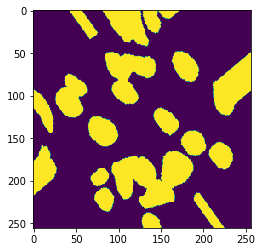

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


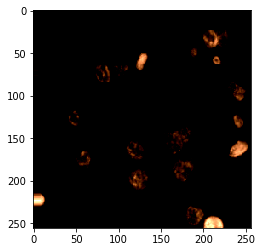

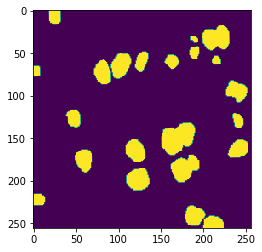

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


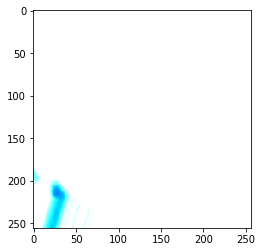

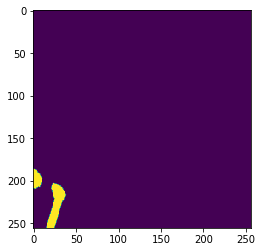

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


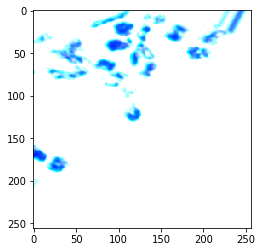

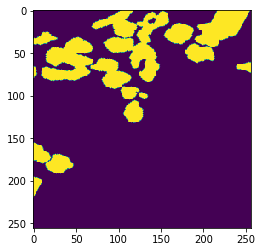

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


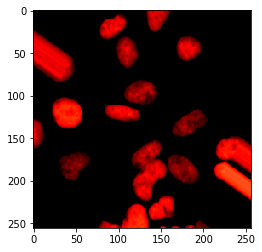

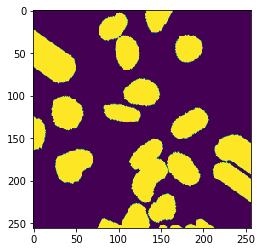

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


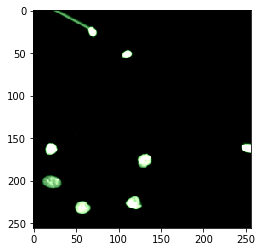

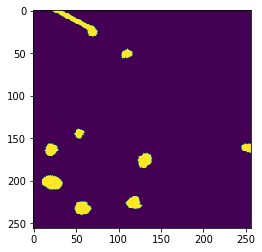

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


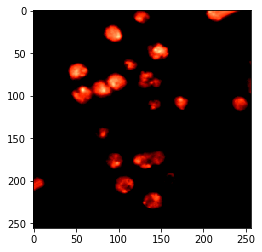

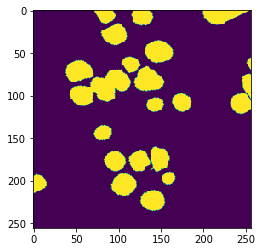

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


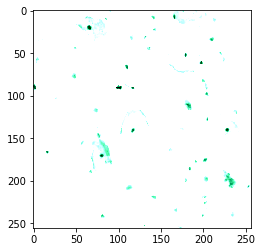

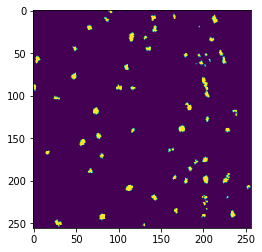

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


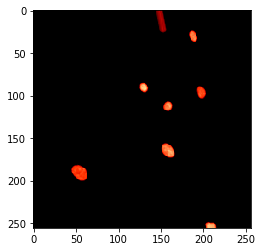

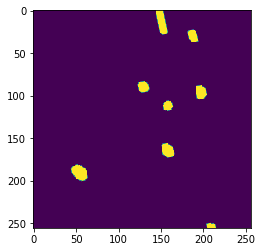

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


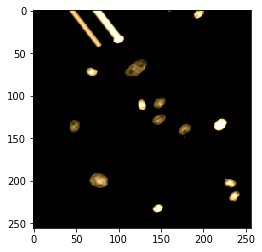

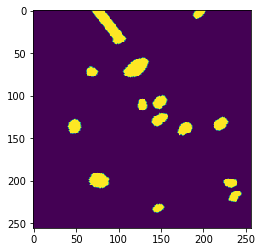

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


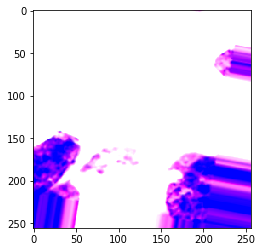

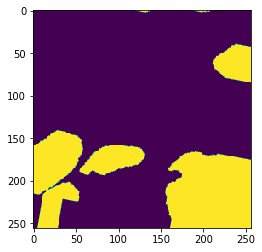

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


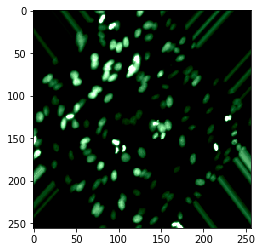

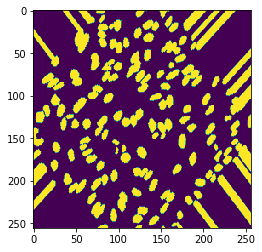

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


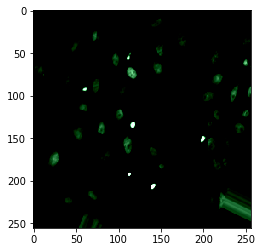

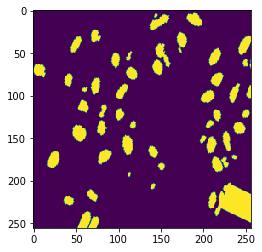

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


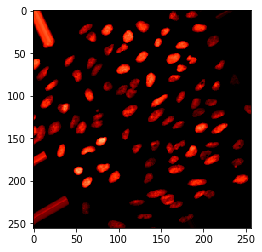

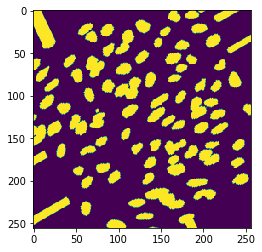

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


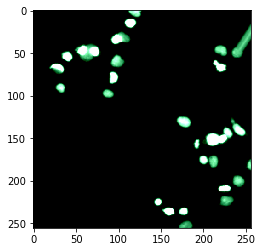

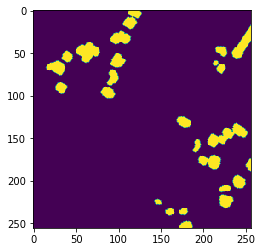

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


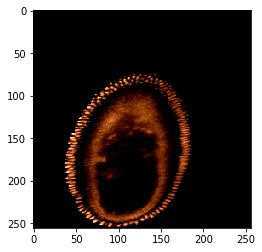

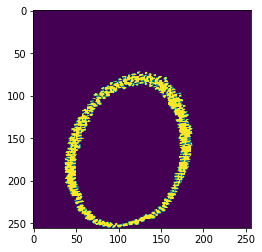

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


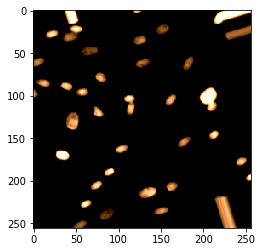

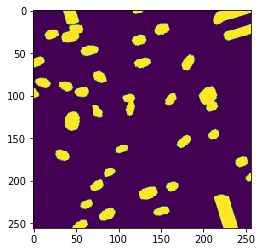

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


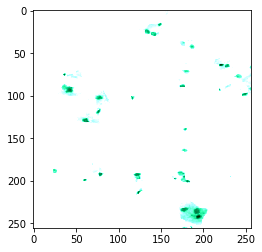

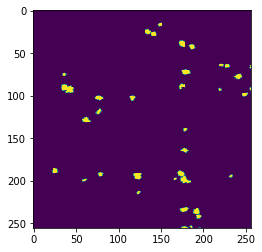

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


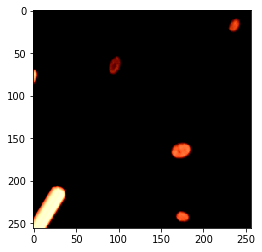

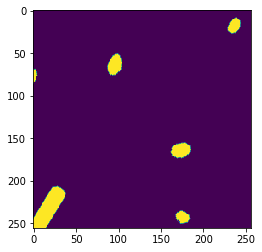

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


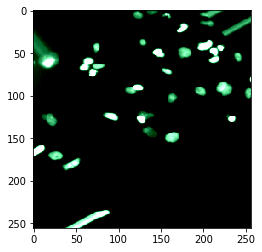

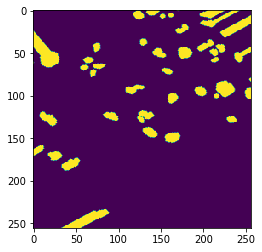

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


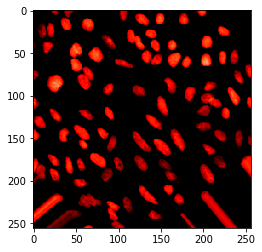

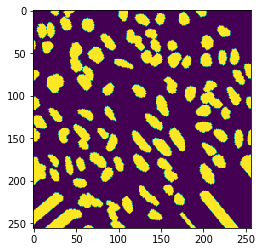

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


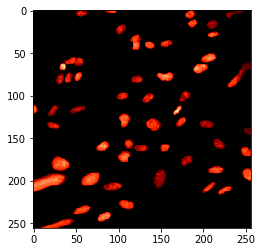

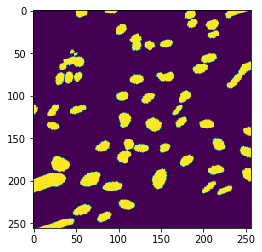

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


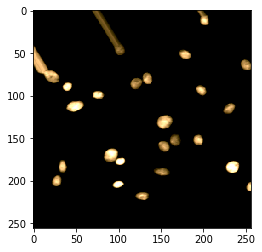

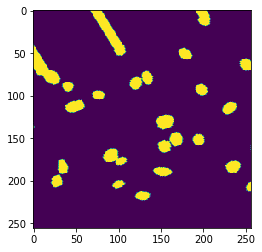

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


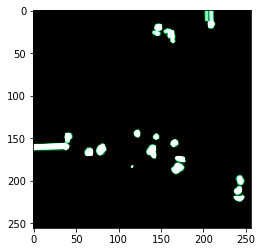

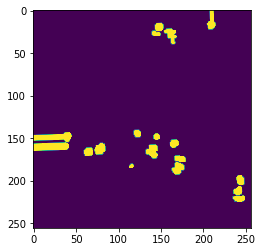

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


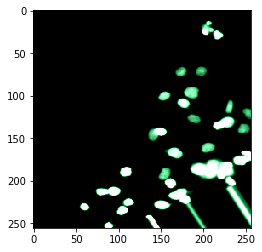

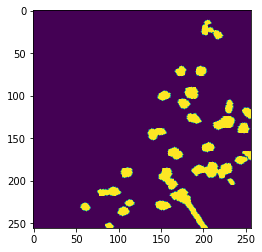

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


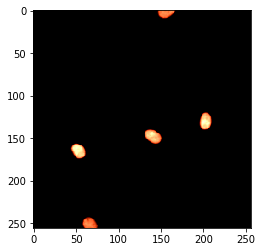

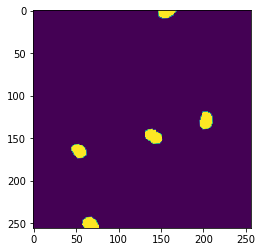

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


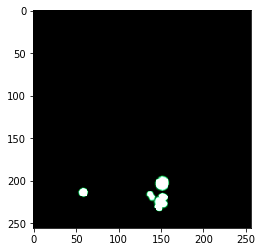

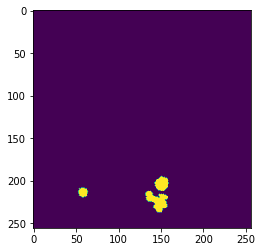

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


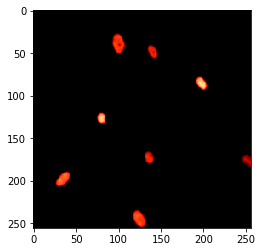

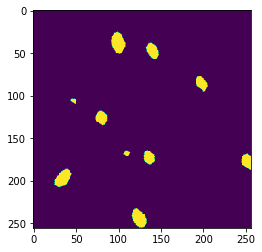

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


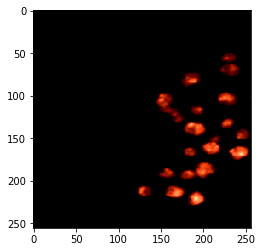

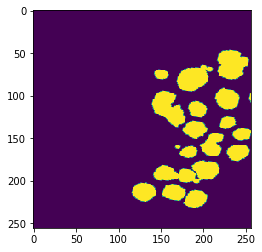

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


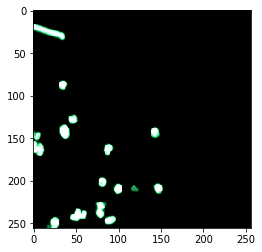

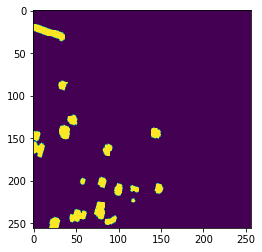

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


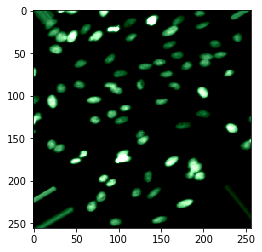

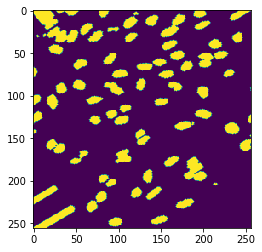

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


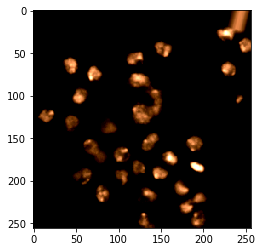

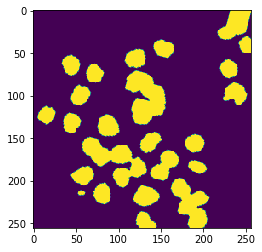

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


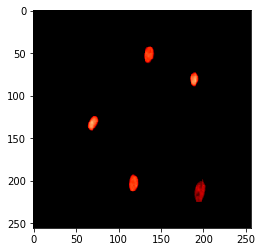

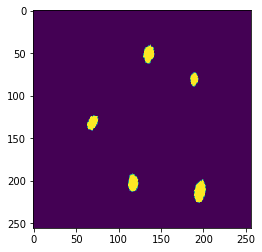

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


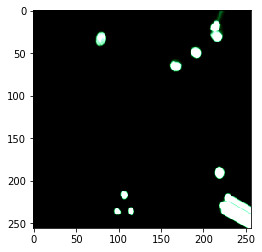

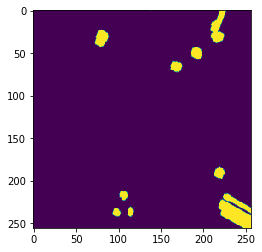

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


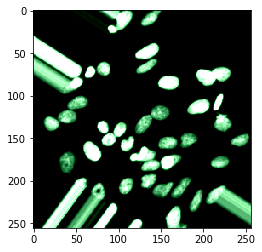

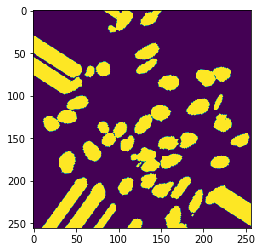

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


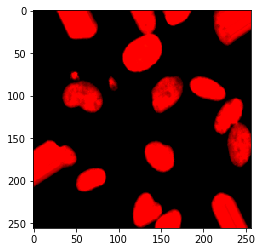

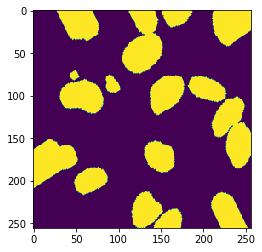

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


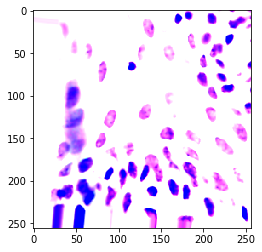

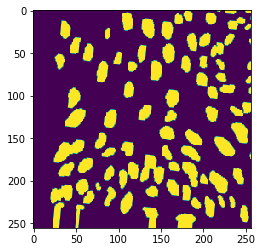

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


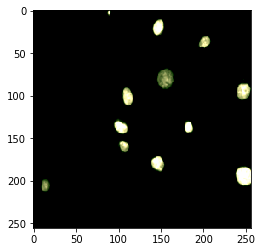

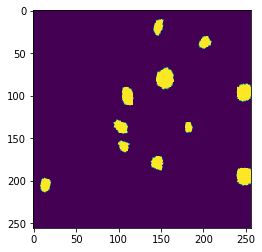

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


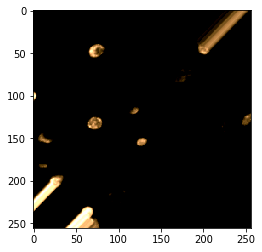

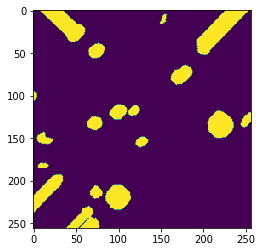

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


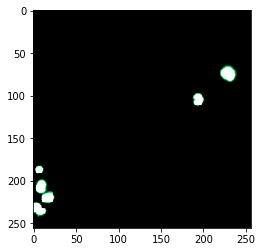

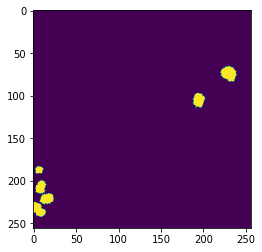

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


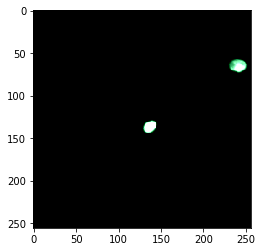

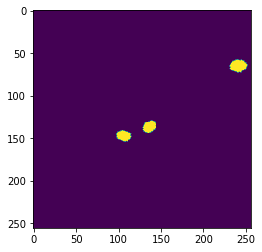

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


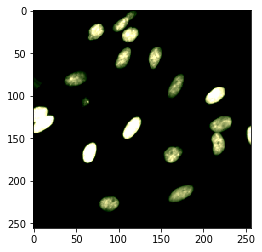

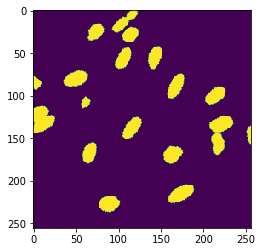

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


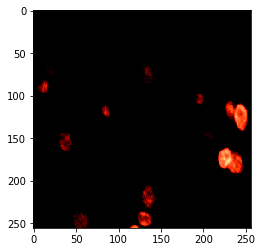

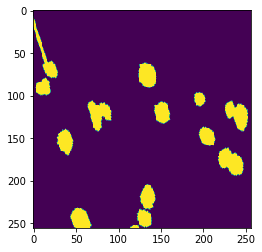

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


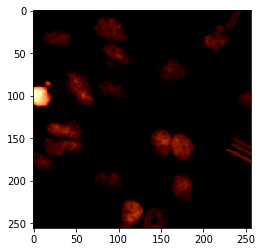

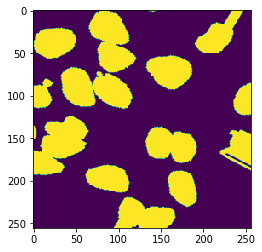

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


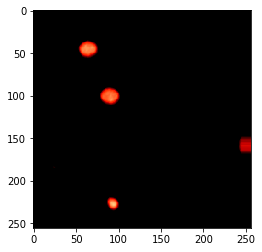

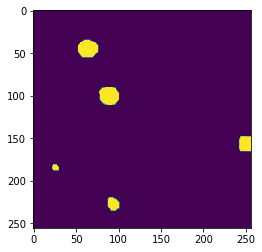

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


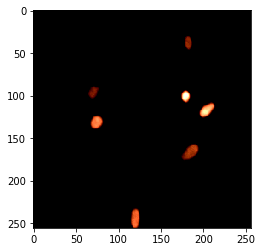

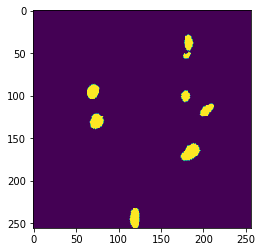

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


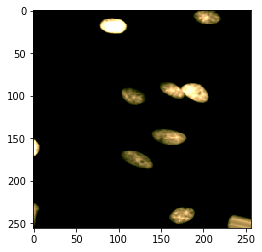

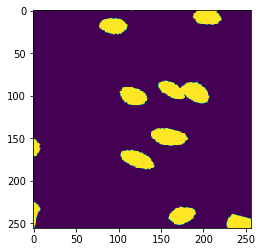

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


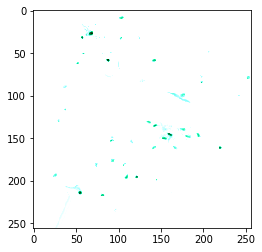

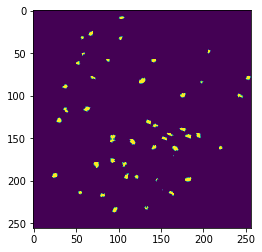

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


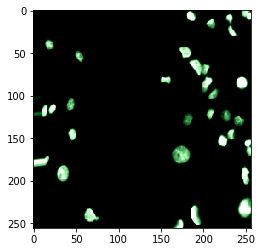

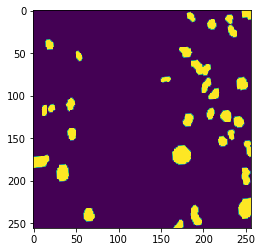

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


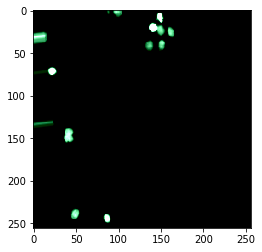

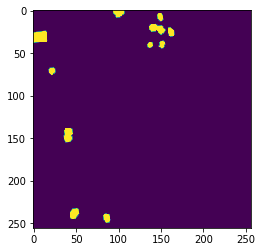

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


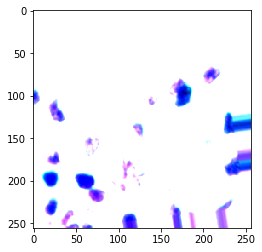

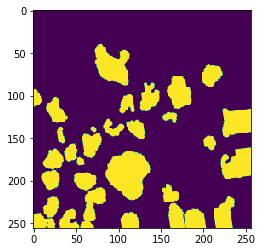

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


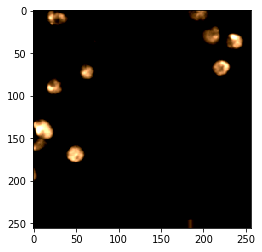

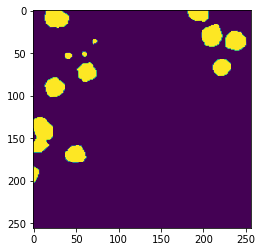

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


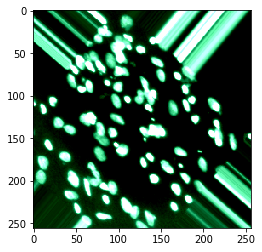

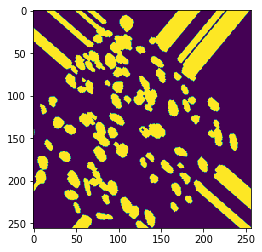

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


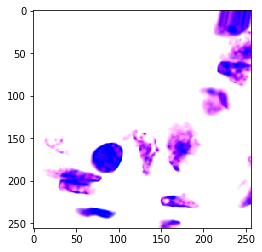

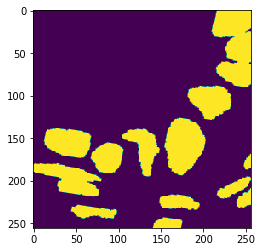

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


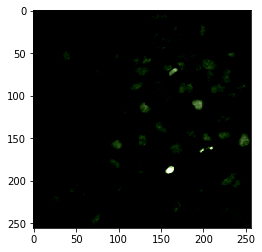

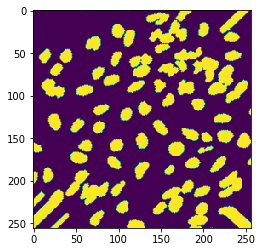

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


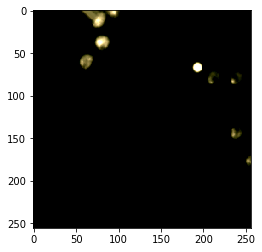

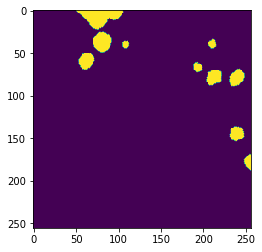

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


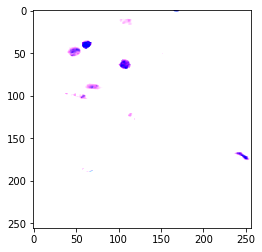

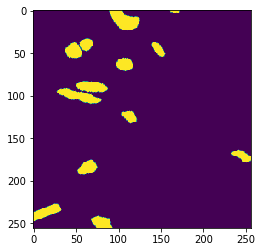

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


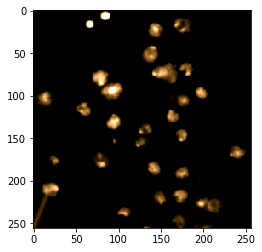

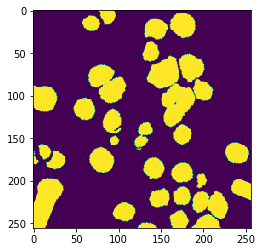

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


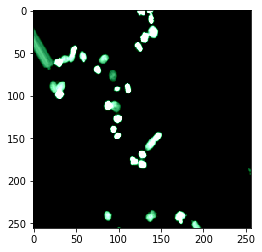

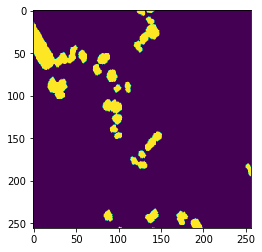

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


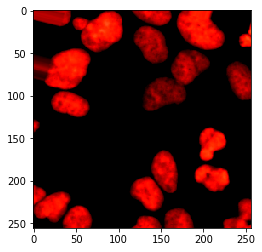

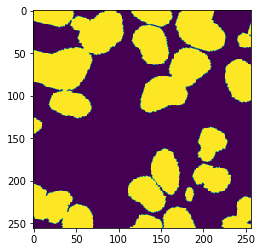

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


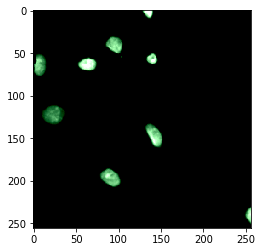

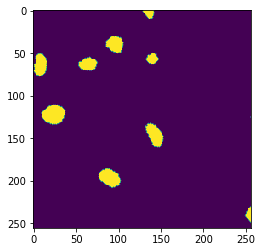

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


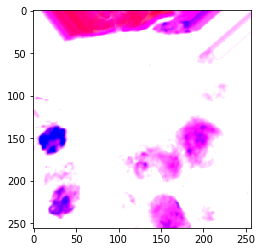

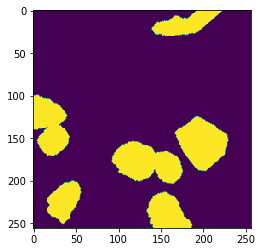

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


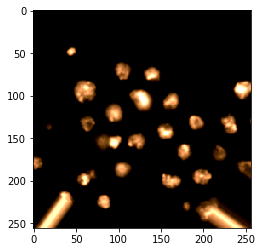

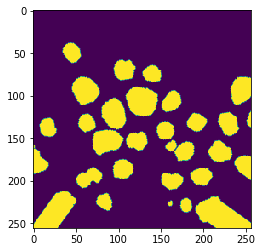

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


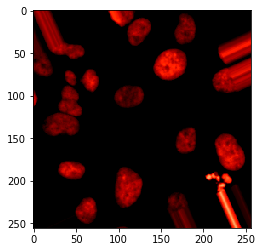

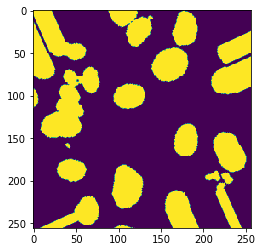

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


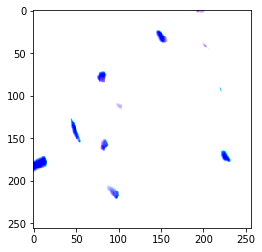

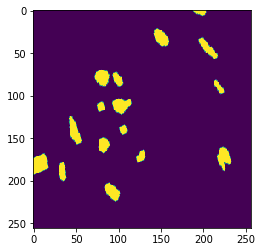

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


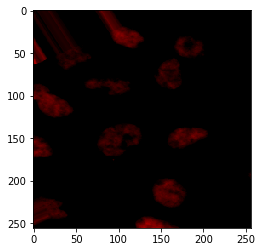

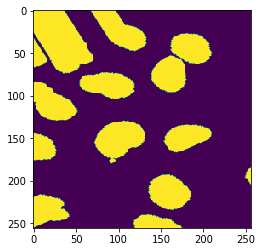

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


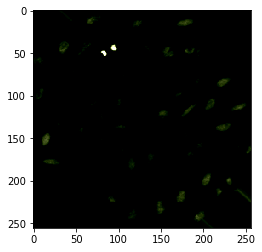

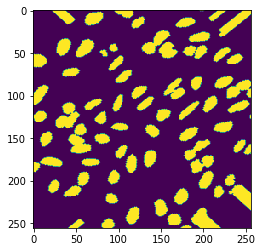

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


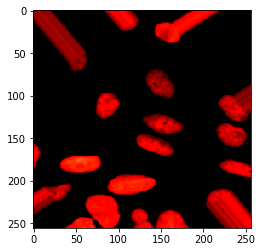

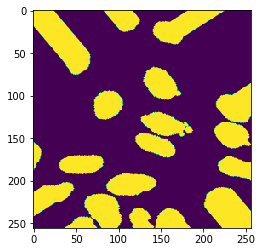

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


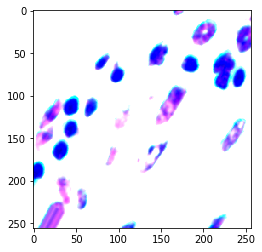

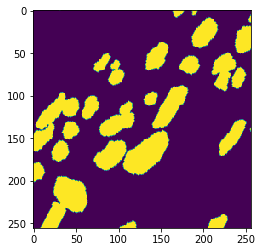

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


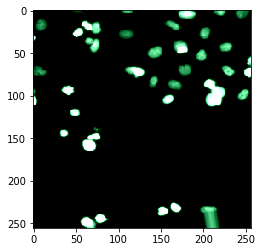

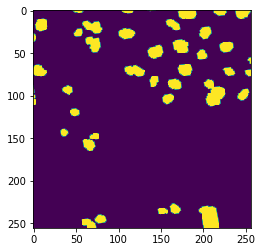

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


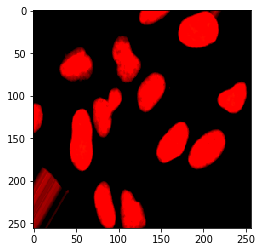

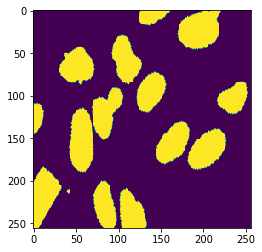

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


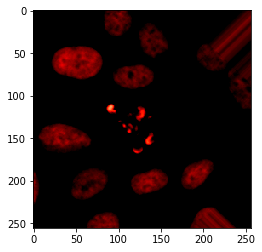

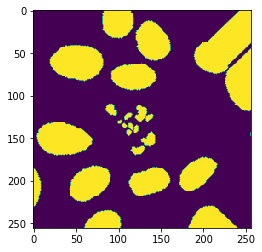

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


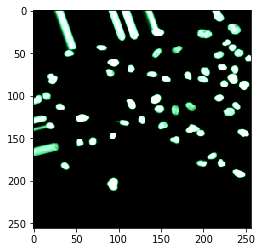

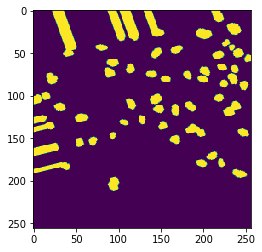

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


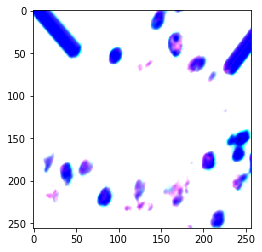

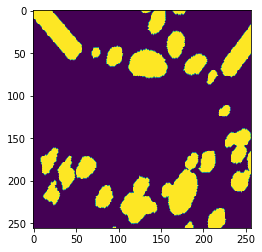

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


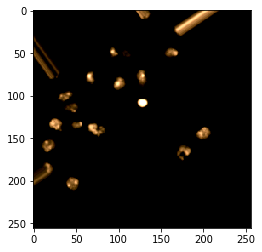

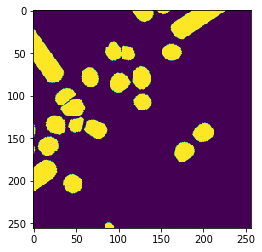

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


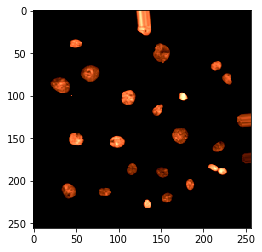

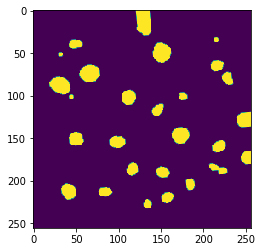

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


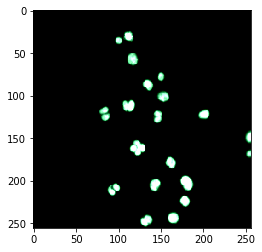

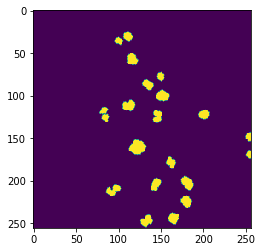

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


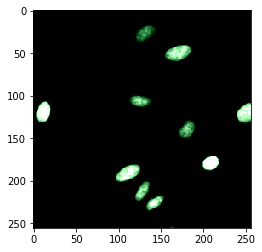

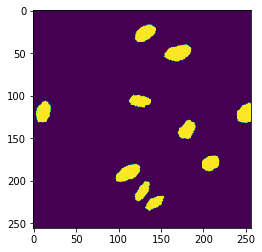

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


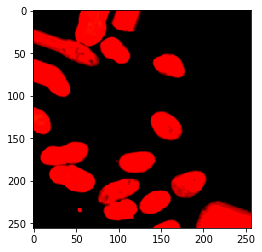

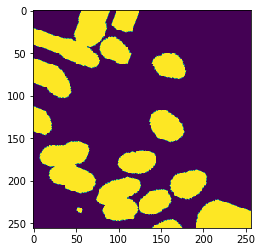

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


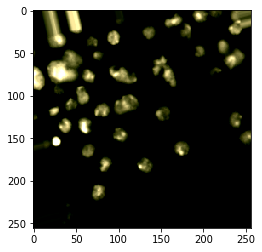

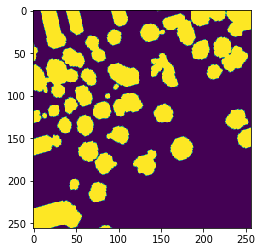

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


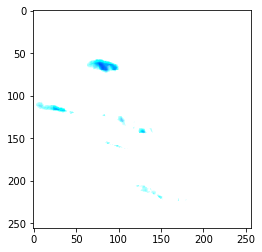

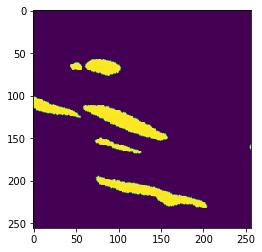

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


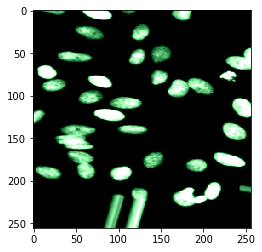

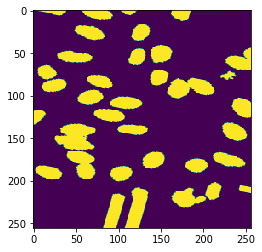

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


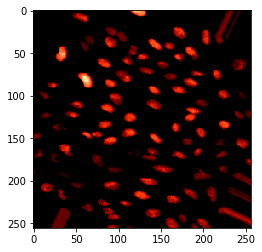

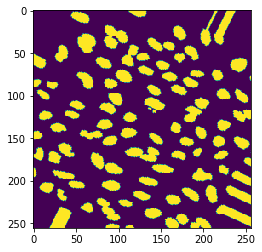

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


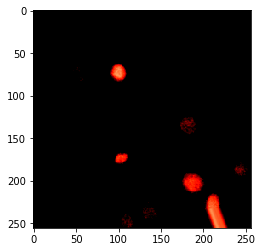

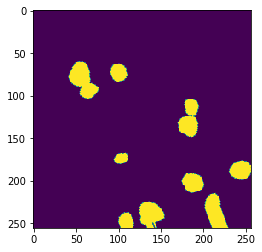

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


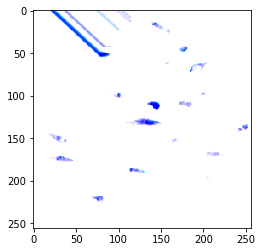

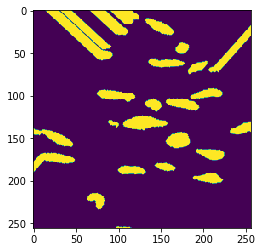

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


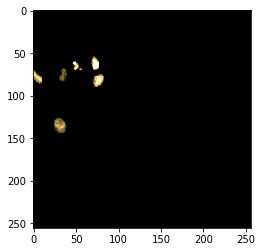

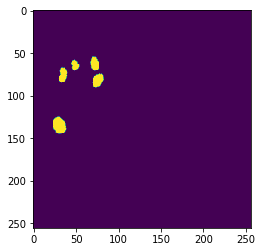

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


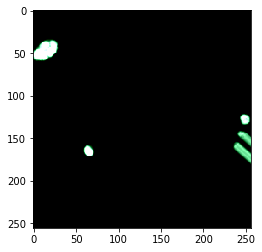

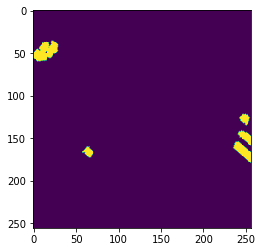

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


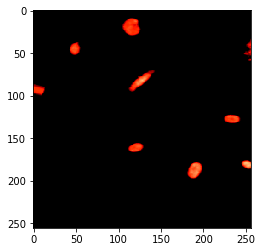

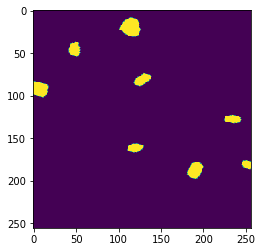

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


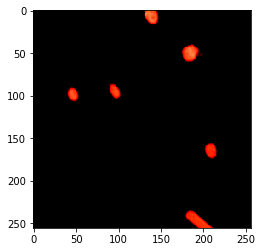

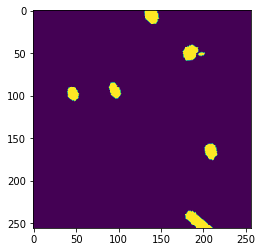

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


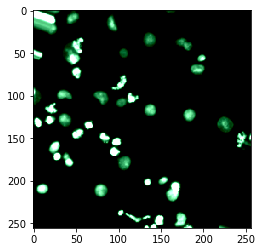

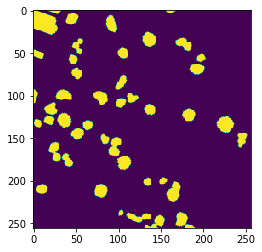

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


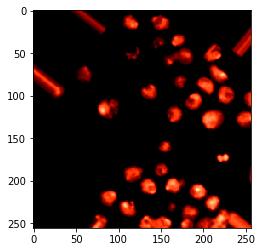

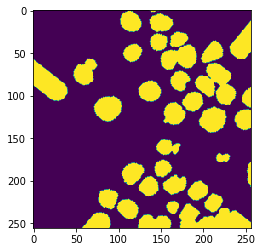

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


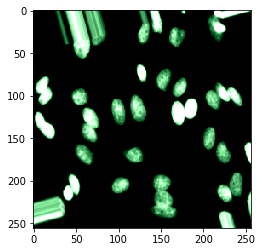

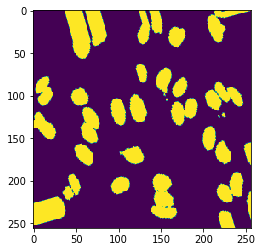

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


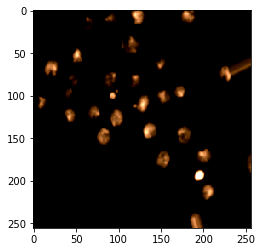

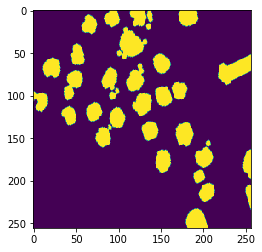

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


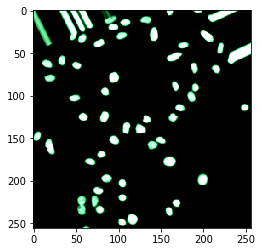

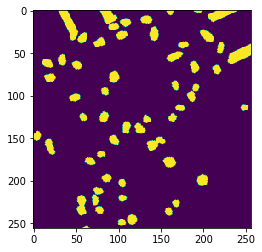

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


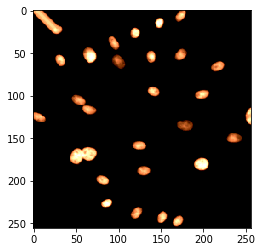

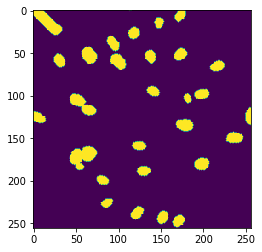

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


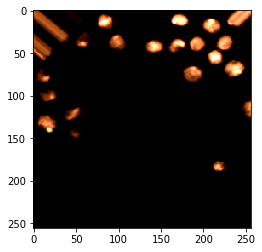

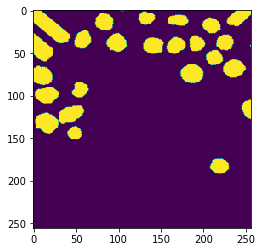

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


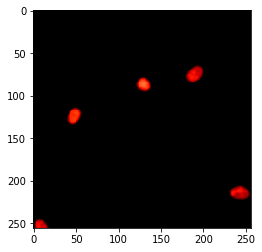

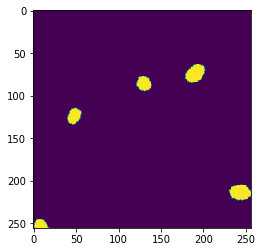

In [77]:
for n in range(0,32):
    x_batchTrain, y_batchTrain = next(trainGenerator)
    for i in range (0,batchSize):
        image = x_batchTrain[i]
        plt.imshow(image)
        plt.show()
        mask = np.squeeze(y_batchTrain[i])
        plt.imshow(mask)
        plt.show()


In [78]:
valDataGenArgs = dict(horizontal_flip=True,
                     featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2) 
valImageDatagen = ImageDataGenerator(**valDataGenArgs)
valMaskDatagen = ImageDataGenerator(**valDataGenArgs)   
valImageDatagen.fit(X_val, seed = seed)
valMaskDatagen.fit(Y_val, seed=seed)
valImageGenerator = valImageDatagen.flow(X_val, batch_size=batchSize, shuffle=True, seed=seed)
valMaskGenerator = valMaskDatagen.flow(Y_val, batch_size=batchSize, shuffle=True, seed=seed)
#combine generators into one which yields image and masks
valGenerator=zip(valImageGenerator, valMaskGenerator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


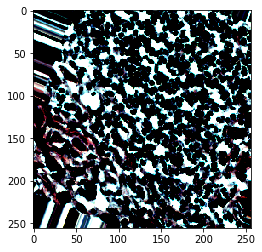

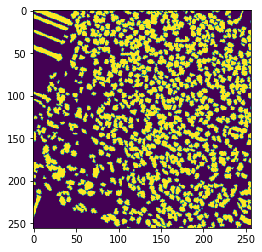

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


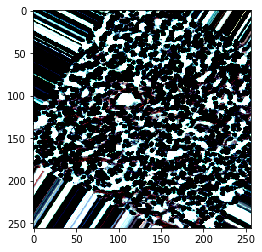

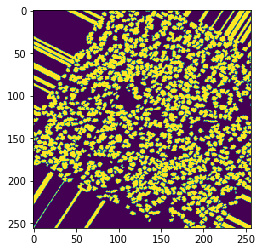

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


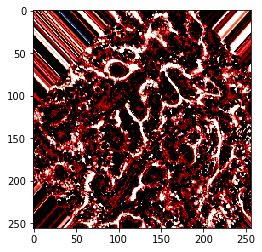

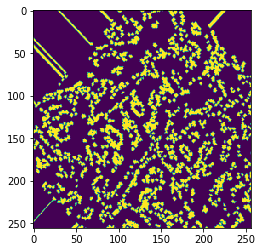

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


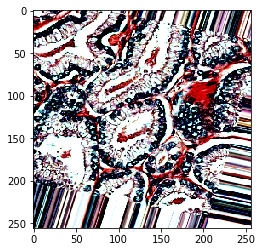

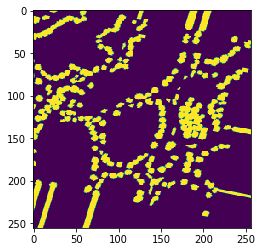

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


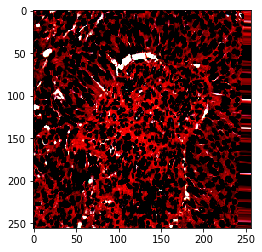

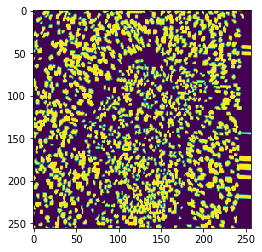

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


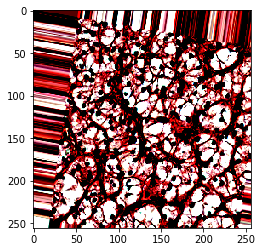

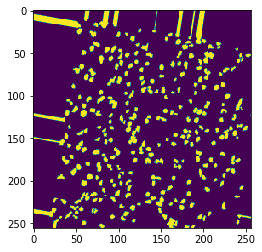

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


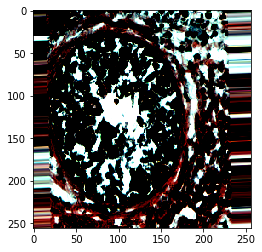

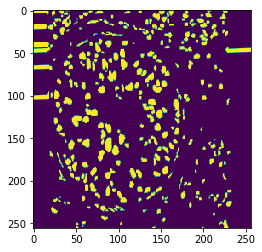

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


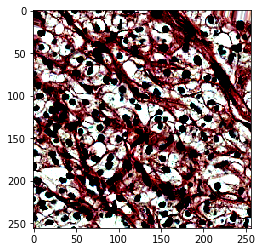

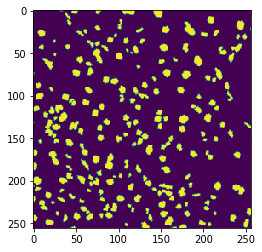

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


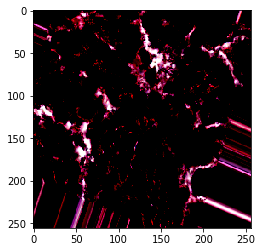

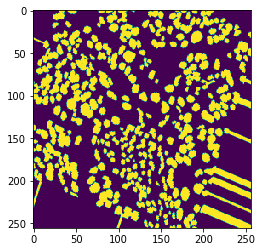

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


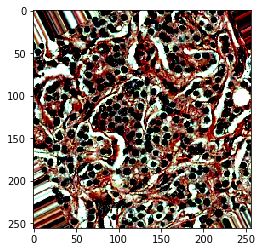

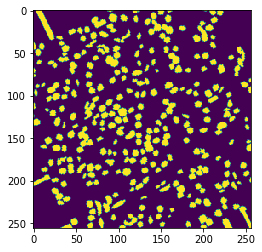

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


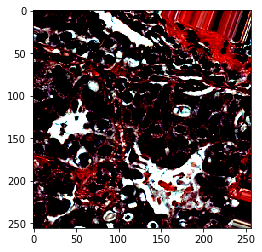

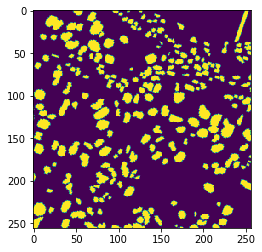

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


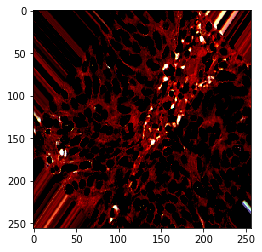

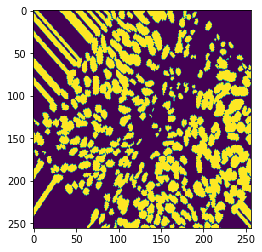

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


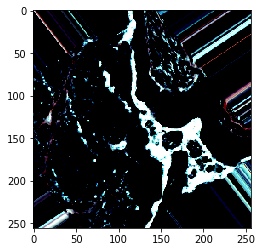

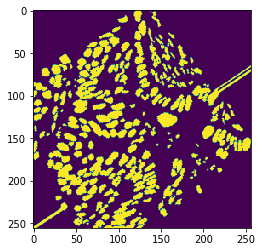

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


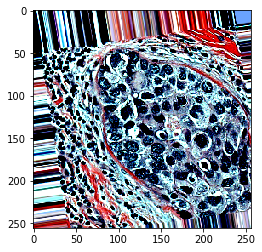

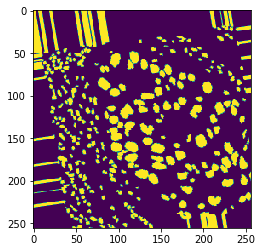

IndexError: index 2 is out of bounds for axis 0 with size 2

In [79]:
for n in valGenerator:
    x_batchVal, y_batchVal = next(valGenerator)
    for i in range (0,batchSize):
        image = x_batchVal[i]
        plt.imshow(image)
        plt.show()
        mask = np.squeeze(y_batchVal[i])
        plt.imshow(mask)
        plt.show()

In [81]:
#callbacks
earlystopper = EarlyStopping(patience=10, verbose=1, monitor='val_loss')
currentModelDir = os.path.join(_modelDir, datetime.now().strftime("%Y-%m-%d %H:%M:%S"),)
if not os.path.exists(currentModelDir):
        os.makedirs(currentModelDir)
filepath = os.path.join(currentModelDir, 'epoch{epoch:04d}-val_loss{val_loss:.2f}.h5')
checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
    
results = u_net.fit_generator(steps_per_epoch=len(X_train)/batchSize,
                        generator=trainGenerator,
                        epochs=60,
                        callbacks=[checkpointer, earlystopper],
                        use_multiprocessing=True,
                        validation_data=valGenerator,
                        validation_steps=len(X_val)/batchSize)

Epoch 1/60
166/166 [==============================] - 20s 122ms/step - loss: 0.1446 - dice_coef: -0.0014 - binary_accuracy: 0.0000e+00 - val_loss: -0.6273 - val_dice_coef: -6.8612e-05 - val_binary_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to -0.62727, saving model to /home/Deep_Learner/work/U-Net/logs/2018-05-25 18:34:20/epoch0001-val_loss-0.63.h5
Epoch 2/60
166/166 [==============================] - 19s 114ms/step - loss: -0.0581 - dice_coef: 1.5245e-05 - binary_accuracy: 0.0000e+00 - val_loss: -0.6273 - val_dice_coef: -6.8612e-05 - val_binary_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from -0.62727
Epoch 3/60
166/166 [==============================] - 19s 114ms/step - loss: -0.1671 - dice_coef: -4.8801e-05 - binary_accuracy: 0.0000e+00 - val_loss: -0.6273 - val_dice_coef: -6.8612e-05 - val_binary_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from -0.62727
Epoch 4/60
166/166 [==============================] - 19s 114ms/step - loss: -0

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [68]:
preds_train_t, preds_val_t, preds_test_upsampled = model.make_predictions('./logs/2018-05-24 19:06:39/epoch0011-val_loss4.22.h5', X_train, X_val, X_test, sizes_test)

3018/3018 [==============================] - 5s 2ms/step


/opt/conda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


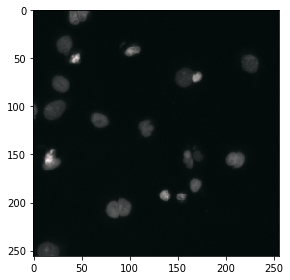

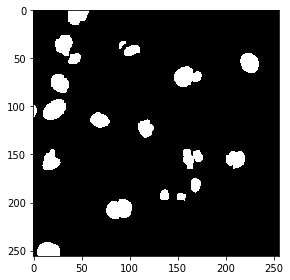

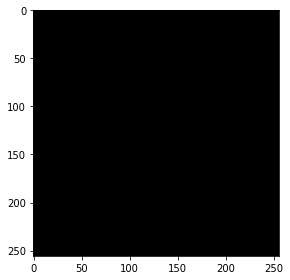

In [69]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

/opt/conda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


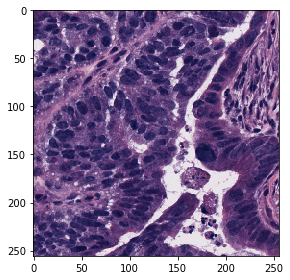

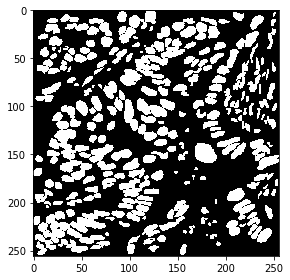

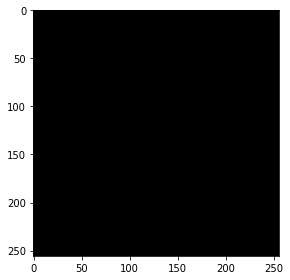

In [70]:
# Perform a sanity check on some random validation samples
"""
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
"""
ix = random.randint(0, len(preds_val_t))
imshow(X_val[ix])
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

and the test data:

/opt/conda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


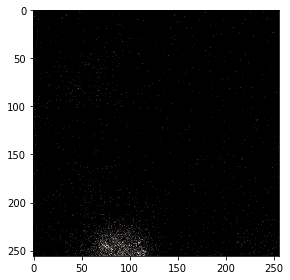

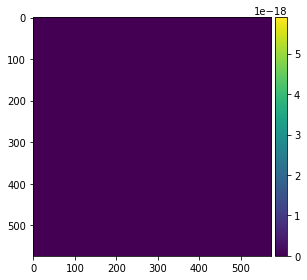

In [71]:
# Perform a sanity check on some random test sample
ix = random.randint(0, len(preds_test_upsampled))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_upsampled[ix]))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [24]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(utils.prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [26]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submissions/sub-dsbowl2018-U-Net_10.csv', index=False)